In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures
import time
import random

## Group Assignment
### Team Number: 15
### Team Member Names: Daniel Eric Jodie
### Team Strategy Chosen: SAFE

In [2]:
##bing s
start = time.perf_counter()
def get_info(stock):
    temp_frame=pd.DataFrame()
    tick = yf.Ticker(stock)
    tick_hist = tick.history(start=start_date,end=end_date)
    if len(tick_hist.index) != 0:
        tick_info = tick.info
        if tick_info['currency'] == 'USD':
            if tick_hist['Volume'].mean()>= 10000:
                for need in hist_need:
                    temp_frame[need+' of '+stock]=tick_hist[need]
                return (temp_frame,stock, tick_info['sector'])
    return pd.DataFrame(),'',''
start_date = '2021-07-02'
end_date = '2021-10-22'
hist_data = pd.DataFrame()
clean_stocks = []
industry_list = []
hist_need = ['Open','High','Low','Close','Volume']
tick_data = pd.read_csv("Tickers.csv",names=["Tickers"])
list_tick = []
for x in range(len(tick_data.index)):
    list_tick.append(tick_data['Tickers'].iloc[x])
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(get_info, list_tick)
    for result in results:
        hist_data = pd.concat([hist_data,result[0]],join='outer',axis=1)
        clean_stocks.append(result[1])
        industry_list.append(result[2])
while True:
    if "" not in clean_stocks:
        break
    else:
        industry_list.remove("")
        clean_stocks.remove("")
finish = time.perf_counter()
print(f'Finished in {round(finish-start,2)} seconds(s)')
hist_data.dropna(inplace=True)
hist_data.head()

- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- PCLN: None
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
Finished in 34.73 seconds(s)


,Open of AAPL,High of AAPL,Low of AAPL,Close of AAPL,Volume of AAPL,Open of ABBV,High of ABBV,Low of ABBV,Close of ABBV,Volume of ABBV,...,Open of UPS,High of UPS,Low of UPS,Close of UPS,Volume of UPS,Open of USB,High of USB,Low of USB,Close of USB,Volume of USB
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,137.899994,140.000000,137.750000,139.960007,78852600.0,111.900746,112.848562,111.285158,112.535881,5719500.0,...,207.463349,209.947891,207.156497,209.383667,2172300.0,57.171395,57.300406,56.744668,57.131699,3520900.0
2021-07-06,140.070007,143.149994,140.070007,142.020004,108181800.0,112.535879,113.249187,112.145027,113.083076,7172100.0,...,208.324538,209.462863,206.077567,209.146103,2421300.0,56.665274,56.893526,55.206468,55.583572,5008700.0
2021-07-07,143.539993,144.889999,142.660004,144.570007,104911600.0,113.258966,114.294720,112.672683,114.079750,6695100.0,...,209.165904,212.749168,208.185959,212.085968,2553700.0,55.246161,56.049996,55.037761,55.563728,5125700.0
2021-07-08,141.580002,144.059998,140.669998,143.240005,105575500.0,113.112394,114.138374,113.034222,113.688896,3948800.0,...,208.185954,210.541795,207.770203,209.918198,2354300.0,54.700349,55.216391,54.253774,54.620960,5977700.0
2021-07-09,142.750000,145.649994,142.649994,145.110001,99890800.0,113.640040,114.646482,113.454384,113.913635,4823400.0,...,211.719726,212.323537,210.512104,211.749420,2050500.0,55.653043,56.605733,55.424791,56.536266,4437300.0


In [3]:
def get_daily_returns(list_of_stock):
    monthly_returns = pd.DataFrame()
    for stock in list_of_stock:
        monthly_returns['Monthly Returns of '+stock] = hist_data['Close of '+stock].pct_change()*100
    monthly_returns.dropna(inplace=True)
    return monthly_returns

def get_beta_total(list_of_stock):
    tot = 0
    for x in range (len(list_of_stock)):
        tot+= beta_vals['Monthly Returns of '+list_of_stock[x]]
    return (tot/len(list_of_stock)).iloc[0]

def get_average_std(list_of_stock):
    tot = 0
    for x in range (len(list_of_stock)):
        tot+= monthly_returns['Monthly Returns of '+list_of_stock[x]].std(axis=0,skipna=True)
    return (tot/len(list_of_stock))

def get_alpha(list_of_stock):
    # Get the current beta column
    column_counter = 1
    alpha = pd.DataFrame()
    for stock in list_of_stock:
        alpha['Alpha '+stock] = monthly_returns['Monthly Returns of '+stock] - ((monthly_returns['Monthly Returns of '+stock].mean()) * beta_vals.iloc[0, column_counter])
        column_counter += 1
    return alpha

# MDD Equation: (Peak Value - Trough Value) / Peak Value
def get_mdd(list_of_stock):
    mdd = []
    for x in range (len(list_of_stock)):
        trough = min(hist_data['Low of '+list_of_stock[x]])
        peak = max(hist_data['High of '+list_of_stock[x]])
        mdd.append((((peak - trough) / peak)))
    return mdd

In [4]:
monthly_returns = get_daily_returns(clean_stocks)
monthly_returns.head()

,Monthly Returns of AAPL,Monthly Returns of ABBV,Monthly Returns of ABT,Monthly Returns of ACN,Monthly Returns of AIG,Monthly Returns of AMZN,Monthly Returns of AXP,Monthly Returns of BA,Monthly Returns of BAC,Monthly Returns of BIIB,...,Monthly Returns of SLB,Monthly Returns of SO,Monthly Returns of SPG,Monthly Returns of T,Monthly Returns of TGT,Monthly Returns of TXN,Monthly Returns of UNH,Monthly Returns of UNP,Monthly Returns of UPS,Monthly Returns of USB
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-06,1.471847,0.486241,0.660795,0.183700,-2.996878,4.692707,0.629081,-0.228153,-2.624553,-1.098299,...,-4.940534,0.178772,-1.535144,-0.718434,-0.458275,-0.525473,0.219863,-0.404951,-0.113459,-2.709750
2021-07-07,1.795524,0.881364,0.883694,1.378522,0.386187,0.566963,0.837459,-1.846363,-0.798599,3.027044,...,-1.572021,0.081111,-1.449386,-0.310138,0.855578,-0.742678,0.341241,2.028508,1.405651,-0.035701
2021-07-08,-0.919971,-0.342615,-0.508889,-0.148580,-4.124817,0.942218,-2.035319,2.152906,-2.440249,3.861200,...,-0.488914,-0.226939,-0.556491,-0.809570,0.416077,-0.811460,-0.415389,-4.383626,-1.022119,-1.696733
2021-07-09,1.305498,0.197679,0.402476,1.122430,4.480600,-0.323466,2.650744,1.191026,3.249103,-2.950815,...,2.161804,-0.129972,3.677358,0.958127,0.000000,1.078409,0.526891,1.534306,0.872351,3.506540
2021-07-12,-0.420371,0.900663,-0.776679,-0.335861,1.216133,-0.021241,0.965453,-0.542595,1.473522,-2.546347,...,0.096184,0.536845,0.447218,0.105441,1.472360,0.867191,0.953630,-0.212007,-0.275798,1.070743


In [5]:
beta_data = pd.DataFrame()
MarketIndex='^GSPC'
marketing_tick = yf.Ticker(MarketIndex)
marketing_hist = marketing_tick.history(start=start_date,end=end_date)
beta_data[MarketIndex] = marketing_hist['Close'].pct_change()*100
beta_data = pd.concat([beta_data, monthly_returns],join='inner',axis=1)
MarketVar= beta_data['^GSPC'].var()
Beta = pd.DataFrame(beta_data.cov() / MarketVar)
beta_vals = pd.DataFrame(Beta.iloc[[0]])
beta_vals.rename(index={'^GSPC': 'Beta'})
beta_vals.head()

,^GSPC,Monthly Returns of AAPL,Monthly Returns of ABBV,Monthly Returns of ABT,Monthly Returns of ACN,Monthly Returns of AIG,Monthly Returns of AMZN,Monthly Returns of AXP,Monthly Returns of BA,Monthly Returns of BAC,...,Monthly Returns of SLB,Monthly Returns of SO,Monthly Returns of SPG,Monthly Returns of T,Monthly Returns of TGT,Monthly Returns of TXN,Monthly Returns of UNH,Monthly Returns of UNP,Monthly Returns of UPS,Monthly Returns of USB
^GSPC,1.0,1.29886,0.668293,0.458501,1.044192,1.484594,1.010834,1.425493,1.443641,1.422094,...,1.673033,0.295347,1.557336,0.659789,0.985832,1.031316,0.91933,1.065526,0.703829,1.257542


We used beta to measure the systematic risk (ie. volatility) of our portfolio value. The beta coefficient measures the volatility of an individual stock relative to the entire market’s systematic risk. This is effective in displaying the activity of a stock’s returns in reaction to rises and dips in the market. As such, it allows us to determine how risky a stock is in comparison to the rest of the market. With our portfolio’s safe strategy, we look for stocks with beta coefficients as close to 0 as possible. A beta coefficient close to 0 deduces that such stocks deviate very little from the market trends and thus, does not add much risk to the portfolio. The stocks that we look to invest in have low monthly returns which means that there is less at stakes. With low-risk investing, targeting stocks with low monthly returns means that we are protected against any possible loss.  

An assumption made of the beta coefficient theory is that the stock returns are normally distributed. However, financial markets are susceptible to unavoidable shock events. As a matter of fact, returns are rarely normally distributed. Thus, the beta coefficient of a stock may be inaccurate when predicting its future movement. For instance, a stock has small price swings (low std) but is in a long-term downward trend. Thus, though the stock is determined as low risk by the beta coefficient, the potential for losses is, in contrary, relatively high. 

Furthermore, a limitation of using beta is that it is mostly accurate and effective in determining short-term risk. Since we calculate beta solely using historical closing prices, it is not as practical in aims of predicting the stock’s future movement. However, 
since the time interval is only 3 months, we concluded that beta is, nevertheless, useful in calculating a stock’s volatility.


In [6]:
alpha = pd.DataFrame()
for stock in clean_stocks:
    alpha['Alpha '+stock] = monthly_returns['Monthly Returns of '+stock] - ((monthly_returns['Monthly Returns of '+stock].mean()) * beta_vals['Monthly Returns of '+stock].iloc[0])
alpha.head()

,Alpha AAPL,Alpha ABBV,Alpha ABT,Alpha ACN,Alpha AIG,Alpha AMZN,Alpha AXP,Alpha BA,Alpha BAC,Alpha BIIB,...,Alpha SLB,Alpha SO,Alpha SPG,Alpha T,Alpha TGT,Alpha TXN,Alpha UNH,Alpha UNP,Alpha UPS,Alpha USB
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-06,1.344169,0.512152,0.617280,-0.016185,-3.461665,4.710646,0.504466,-0.058876,-2.906870,-0.965395,...,-5.107431,0.156755,-1.809882,-0.658013,-0.511369,-0.607884,0.110262,-0.462445,-0.068655,-2.872806
2021-07-07,1.667846,0.907275,0.840179,1.178637,-0.078600,0.584902,0.712843,-1.677085,-1.080916,3.159947,...,-1.738918,0.059095,-1.724124,-0.249718,0.802484,-0.825089,0.231641,1.971014,1.450455,-0.198758
2021-07-08,-1.047649,-0.316703,-0.552404,-0.348466,-4.589605,0.960157,-2.159935,2.322183,-2.722566,3.994103,...,-0.655811,-0.248956,-0.831229,-0.749149,0.362983,-0.893871,-0.524990,-4.441120,-0.977315,-1.859789
2021-07-09,1.177819,0.223590,0.358961,0.922544,4.015813,-0.305527,2.526128,1.360303,2.966786,-2.817912,...,1.994907,-0.151988,3.402620,1.018548,-0.053094,0.995998,0.417291,1.476812,0.917154,3.343484
2021-07-12,-0.548049,0.926574,-0.820194,-0.535747,0.751345,-0.003302,0.840838,-0.373318,1.191205,-2.413443,...,-0.070713,0.514829,0.172479,0.165862,1.419266,0.784781,0.844030,-0.269501,-0.230994,0.907687


In [7]:
start = time.perf_counter()
tech_list = []
health_list = []
industrial_list = []
finance_list = []
defensive_list = []
cyclical_list = []
real_estate_list = []
energy_list = []
materials_list = []
communication_list = []
utilities_list = []

for (industry,stock) in zip(industry_list,clean_stocks):
    if industry == "Technology":
        tech_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Healthcare":
        health_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Industrials":
        industrial_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Financial Services":
        finance_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Consumer Defensive":
        defensive_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Consumer Cyclical":
        cyclical_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Real Estate":
        real_estate_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Energy":
        energy_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Basic Materials":
        materials_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Communication Services":
        communication_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Utilities":
        utilities_list.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),stock))
list_of_industries = [tech_list,health_list,industrial_list,finance_list,defensive_list,cyclical_list,real_estate_list,energy_list,materials_list,communication_list,utilities_list]

finish = time.perf_counter()
print(f'Finished in {round(finish-start,2)} seconds(s)')

Finished in 0.0 seconds(s)


In [8]:
tech_list.sort()
health_list.sort()
industrial_list.sort()
finance_list.sort()
defensive_list.sort()
cyclical_list.sort()
real_estate_list.sort()
energy_list.sort()
materials_list.sort()
communication_list.sort()
utilities_list.sort()

In [9]:
total_list = []
if len(tech_list)!=0:
    total_list.append(tech_list[0][1])
    
if len(health_list)!=0:
    total_list.append(health_list[0][1])
    
if len(industrial_list)!=0:
    total_list.append(industrial_list[0][1])
    
if len(finance_list)!=0:
    total_list.append(finance_list[0][1])
    
if len(defensive_list)!=0:
    total_list.append(defensive_list[0][1])
    
if len(cyclical_list)!=0:
    total_list.append(cyclical_list[0][1])
    
if len(real_estate_list)!=0:
    total_list.append(real_estate_list[0][1])
    
if len(energy_list)!=0:
    total_list.append(energy_list[0][1])
    
if len(materials_list)!=0:
    total_list.append(materials_list[0][1])
    
if len(communication_list)!=0:
    total_list.append(communication_list[0][1])
    
if len(utilities_list)!=0:
    total_list.append(utilities_list[0][1])
    

In [10]:
total_list 

['CSCO', 'BMY', 'LMT', 'MON', 'PG', 'SBUX', 'SPG', 'KMI', 'T', 'SO']

In [11]:
alpha_mean = []
alpha = get_alpha(total_list)
alpha.head()

,Alpha CSCO,Alpha BMY,Alpha LMT,Alpha MON,Alpha PG,Alpha SBUX,Alpha SPG,Alpha KMI,Alpha T,Alpha SO
Date,,,,,,,,,,
2021-07-06,-1.122992,-0.324695,-0.731936,0.761834,-0.021390,0.659973,-1.786623,-0.635300,-0.588205,0.148932
2021-07-07,0.451457,0.858574,1.277495,-0.014964,0.669856,1.217278,-1.700865,-0.694482,-0.179909,0.051271
2021-07-08,-0.077042,-0.546842,-0.921076,0.180309,-0.094861,-0.982804,-0.807970,-0.645640,-0.679341,-0.256780
2021-07-09,0.824203,0.828147,0.846902,-0.897100,-0.043747,1.274904,3.425879,2.816535,1.088356,-0.159812
2021-07-12,-1.026060,0.629631,-1.047258,0.367937,0.000020,0.841695,0.195739,-0.738676,0.235671,0.507005


Alpha is used to measure the daily stock return in comparison to the market index that it is compared against. The number output represents a percentage above or below the benchmark index. note that alpha is calculated using historical closing prices so it does not indicate any future trends. 

In [12]:
mdd = get_mdd(total_list)
mdd

[0.13157458511607295,
 0.18105057874970099,
 0.12263098504021946,
 0.034170870261855966,
 0.08636837024342507,
 0.1338663400377423,
 0.21786154608093122,
 0.17537307844185201,
 0.09811904564705402,
 0.10941946845955973]

Maximum Drawdown (MDD) was used to measure the maximum historical loss and to analyze the downside risk over our 3 month interval. This is used to analyze our stock weighting strategy relative to other weightings, which is one of our primary concerns. For instance, two different portfolio weightings can output the same volatility and performance on average but their maximum drawdowns would be different. This is how we distinguish between a stock with low volatility, consistent average performance, but high maximum drawdown with low volatility, consistent average performance, and low maximum drawdown. As such, low maximum drawdown is always preferred since this deduces that there were minimal losses from the investment. In the case that a maximum drawdown is zero, this would indicate that the stock never lost any money. A stock with 0 maximum drawdown is what we aim to weigh the highest since it entails the least loss. 

Furthermore, in diversifying our portfolio, drawdown risk is reduced; this is because different industry market conditions impact different stocks in different ways. As we explored in Assignment 4, when investing all stocks in the same industry, assets are at a  greater risk of loss. This is why inter-industry investments are a large factor of our safe strategy. by investing in other industries, each stock will react differently to the same market event. For instance, when the market of one industry is growing, the stocks of that industry tend to outperform stocks from other industries. On the contrary, when the market for one industry starts to slow down, stocks from other industries start outperforming this industry’s stocks. as such, by holding inter-industry investments, we are minimizing the fluctuation of our overall portfolio when the market swings one way of another.  

Note that some investors use the equation: (Trough - Peak) / Peak to calculate maximum drawdown (which will entail a negative value). However, since our sole purpose of measuring maximum drawdown is to find the greatest movement from a high point to a low point, we use (Peak - Trough) / Peak ; this is essentially the same as the absolute value of (Trough-Peak)/ Peak. 

However, one limitation of using maximum drawdown is that it does not indicate how long it took for the stock to recover from the loss, or if the investment ever recovers. Additionally, since maximum drawdown only measures the largest drawdown, other smaller periods are ignored— this may cause an inaccurate interpretation of the stock. 

Nevertheless, since our main focus in calculating maximum drawdown is to see the largest deviation between the highest point and the lowest point of the stock, smaller periods of loss/gains are insignificant for our analysis. 


In [13]:
for x in range (len(total_list)):
    clean_stocks.remove(total_list[x])

In [14]:
total_list

['CSCO', 'BMY', 'LMT', 'MON', 'PG', 'SBUX', 'SPG', 'KMI', 'T', 'SO']

In [15]:
list_of_beta = []
for stock in clean_stocks:
    list_of_beta.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),beta_vals["Monthly Returns of "+stock].iloc[0],stock))
list_of_beta.sort()
list_of_beta

[(0.7688321597213277, 0.526987038764354, 'KO'),
 (0.811354836182049, 0.34706343027461595, 'PEP'),
 (0.947398341943153, 0.33995350967060695, 'CL'),
 (0.9523069502242613, 0.6337507648890615, 'COST'),
 (1.0415131105322977, 0.45850097734735673, 'ABT'),
 (1.046658278251328, 1.044191528229134, 'ACN'),
 (1.1008407434985832, 1.110839403878743, 'MSFT'),
 (1.1528168917845187, 0.40040393314666284, 'NEE'),
 (1.1976737036390077, 1.2824741684772516, 'GOOG'),
 (1.1998659276253096, 0.7547429761038534, 'CVS'),
 (1.2195931497649366, 0.7962338413367872, 'MO'),
 (1.2264115916815697, 0.9858317944917501, 'TGT'),
 (1.2565351315580555, 0.6678546757493694, 'PM'),
 (1.2572305193191413, 0.6682934703236691, 'ABBV'),
 (1.263780051997507, 1.0655260248317286, 'UNP'),
 (1.2807820573294402, 1.2988599511563972, 'AAPL'),
 (1.3080834411931583, 0.9193301920783156, 'UNH'),
 (1.3491541086543088, 1.031316188661969, 'TXN'),
 (1.3514651550070829, 0.8365165532705621, 'NKE'),
 (1.3799141849863301, 0.7130210606742565, 'ORCL'),
 (

In [16]:
threshold = 0
while threshold < len(clean_stocks):
    if len(total_list) == 20:
        break
    beta_temp = get_beta_total(total_list)
    std_temp = get_average_std(total_list)
    beta_stock = list_of_beta[threshold][1]
    std_stock = list_of_beta[threshold][0]
    stock = list_of_beta[threshold][2]
#    print(std_temp,std_stock)
    if beta_stock <= beta_temp and std_stock < std_temp:
        total_list.append(stock)
        clean_stocks.remove(stock)
        list_of_beta.pop(threshold)
        threshold-=1
    threshold+=1
while len(total_list) != 20:
    total_list.append(list_of_beta[0][2])
    list_of_beta.pop(0)
print(total_list)
        

['CSCO', 'BMY', 'LMT', 'MON', 'PG', 'SBUX', 'SPG', 'KMI', 'T', 'SO', 'KO', 'PEP', 'CL', 'COST', 'ABT', 'ACN', 'MSFT', 'NEE', 'GOOG', 'CVS']


In [17]:
final_returns = get_daily_returns(total_list)
final_returns.head()

,Monthly Returns of CSCO,Monthly Returns of BMY,Monthly Returns of LMT,Monthly Returns of MON,Monthly Returns of PG,Monthly Returns of SBUX,Monthly Returns of SPG,Monthly Returns of KMI,Monthly Returns of T,Monthly Returns of SO,Monthly Returns of KO,Monthly Returns of PEP,Monthly Returns of CL,Monthly Returns of COST,Monthly Returns of ABT,Monthly Returns of ACN,Monthly Returns of MSFT,Monthly Returns of NEE,Monthly Returns of GOOG,Monthly Returns of CVS
Date,,,,,,,,,,,,,,,,,,,,
2021-07-06,-1.045950,-0.448087,-0.739197,0.776798,0.058867,0.661044,-1.535144,-0.700046,-0.718434,0.178772,-0.553709,0.147741,0.330478,-0.020057,0.660795,0.183700,0.003605,1.144311,0.817286,-1.516439
2021-07-07,0.528499,0.735182,1.270234,0.000000,0.750113,1.218350,-1.449386,-0.759228,-0.310138,0.081111,0.816627,0.442559,0.841784,1.459159,0.883694,1.378522,0.817543,0.266216,0.236190,0.197094
2021-07-08,0.000000,-0.670234,-0.928338,0.195273,-0.014604,-0.981733,-0.556491,-0.710386,-0.809570,-0.226939,-0.349777,0.046737,-0.387135,0.610355,-0.508889,-0.148580,-0.896645,-0.265509,-0.692280,-1.376927
2021-07-09,0.901246,0.704755,0.839640,-0.882137,0.036510,1.275975,3.677358,2.751789,0.958127,-0.129972,0.609640,-0.253573,0.109297,1.282083,0.402476,1.122430,0.187437,-0.186334,0.307715,1.371226
2021-07-12,-0.949018,0.506239,-1.054519,0.382901,0.080277,0.842767,0.447218,-0.803422,0.105441,0.536845,0.036727,0.020069,0.606580,-1.088820,-0.776679,-0.335861,-0.223068,0.133341,0.763655,0.614853


In [18]:
correlation_values = pd.DataFrame(final_returns.corr())
correlation_values.head()

,Monthly Returns of CSCO,Monthly Returns of BMY,Monthly Returns of LMT,Monthly Returns of MON,Monthly Returns of PG,Monthly Returns of SBUX,Monthly Returns of SPG,Monthly Returns of KMI,Monthly Returns of T,Monthly Returns of SO,Monthly Returns of KO,Monthly Returns of PEP,Monthly Returns of CL,Monthly Returns of COST,Monthly Returns of ABT,Monthly Returns of ACN,Monthly Returns of MSFT,Monthly Returns of NEE,Monthly Returns of GOOG,Monthly Returns of CVS
Monthly Returns of CSCO,1.000000,0.433556,0.271885,0.155844,0.416065,0.336440,0.377545,0.268891,0.405776,0.216074,0.464547,0.367055,0.257447,0.442122,0.354090,0.593066,0.578535,0.187757,0.524230,0.377464
Monthly Returns of BMY,0.433556,1.000000,0.268171,0.032377,0.349728,0.175728,0.170115,0.051525,0.341160,0.273545,0.352593,0.329492,0.301257,0.223678,0.388126,0.420419,0.429626,0.241950,0.190694,0.491485
Monthly Returns of LMT,0.271885,0.268171,1.000000,-0.090981,0.044505,0.265438,0.261668,0.319884,0.342638,0.123065,0.294585,0.227368,0.104034,0.266452,0.047145,0.308594,0.196354,0.003775,0.144177,0.476443
Monthly Returns of MON,0.155844,0.032377,-0.090981,1.000000,0.026131,0.146070,0.013273,-0.041035,-0.004390,-0.040426,0.045740,0.065712,-0.020418,0.067135,0.063011,0.119582,0.097266,0.015819,0.159905,0.010603
Monthly Returns of PG,0.416065,0.349728,0.044505,0.026131,1.000000,0.197384,0.074278,-0.002834,0.210842,0.464958,0.552414,0.627632,0.415837,0.323986,0.397192,0.385521,0.325454,0.355242,0.190129,0.253768


In [19]:
final_beta_std = []
for stock in total_list:
    final_beta_std.append((final_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),beta_vals["Monthly Returns of "+stock].iloc[0],stock))
final_beta_std.sort()
final_beta_std

[(0.4310261262982297, 0.027635681230019405, 'MON'),
 (0.7601239943790068, 0.26914548375987096, 'PG'),
 (0.7688321597213277, 0.526987038764354, 'KO'),
 (0.811354836182049, 0.34706343027461595, 'PEP'),
 (0.8252266938315554, 0.29534663065496713, 'SO'),
 (0.8713513443562145, 0.6597886047105088, 'T'),
 (0.947398341943153, 0.33995350967060695, 'CL'),
 (0.9523069502242613, 0.6337507648890615, 'COST'),
 (0.9653513769944979, 0.5331469509993096, 'LMT'),
 (1.0195849623485882, 0.6229328630744412, 'BMY'),
 (1.0415131105322977, 0.45850097734735673, 'ABT'),
 (1.045844823063707, 0.9081906537432258, 'CSCO'),
 (1.046658278251328, 1.044191528229134, 'ACN'),
 (1.1008407434985832, 1.110839403878743, 'MSFT'),
 (1.1528168917845187, 0.40040393314666284, 'NEE'),
 (1.1976737036390077, 1.2824741684772516, 'GOOG'),
 (1.1998659276253096, 0.7547429761038534, 'CVS'),
 (1.223459855962659, 0.8132890869450996, 'SBUX'),
 (1.6361717355117162, 1.0603009240188321, 'KMI'),
 (1.8787728953059228, 1.5573359928960437, 'SPG')]

In [20]:
print(get_average_std(total_list))
print(get_beta_total(total_list))

1.0438087375726968
0.682301030140698


In [21]:
list_of_beta = []
for stock in clean_stocks:
    list_of_beta.append((monthly_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),beta_vals["Monthly Returns of "+stock].iloc[0],stock))
list_of_beta.sort()

In [22]:
threshold = 0
while threshold < len(clean_stocks):
    if len(total_list) == 20:
        break
    beta_temp = get_beta_total(total_list)
    std_temp = get_average_std(total_list)
    beta_stock = list_of_beta[threshold][1]
    std_stock = list_of_beta[threshold][0]
    stock = list_of_beta[threshold][2]
#    print(std_temp,std_stock)
    if std_stock < std_temp:
        if (beta_stock <= beta_temp and beta_temp >= 0) or (beta_stock >= beta_temp and beta_temp < 0):
            total_list.append(stock)
            clean_stocks.remove(stock)
            list_of_beta.pop(threshold)
            threshold-=1
    threshold+=1
counting = 0
while len(total_list) != 20 or len(clean_stocks) ==0 :
    total_list.append(list_of_beta[0][2])
    list_of_beta.pop(0)
print(total_list)

['CSCO', 'BMY', 'LMT', 'MON', 'PG', 'SBUX', 'SPG', 'KMI', 'T', 'SO', 'KO', 'PEP', 'CL', 'COST', 'ABT', 'ACN', 'MSFT', 'NEE', 'GOOG', 'CVS']


In [23]:
final_returns = get_daily_returns(total_list)
final_returns.head()

,Monthly Returns of CSCO,Monthly Returns of BMY,Monthly Returns of LMT,Monthly Returns of MON,Monthly Returns of PG,Monthly Returns of SBUX,Monthly Returns of SPG,Monthly Returns of KMI,Monthly Returns of T,Monthly Returns of SO,Monthly Returns of KO,Monthly Returns of PEP,Monthly Returns of CL,Monthly Returns of COST,Monthly Returns of ABT,Monthly Returns of ACN,Monthly Returns of MSFT,Monthly Returns of NEE,Monthly Returns of GOOG,Monthly Returns of CVS
Date,,,,,,,,,,,,,,,,,,,,
2021-07-06,-1.045950,-0.448087,-0.739197,0.776798,0.058867,0.661044,-1.535144,-0.700046,-0.718434,0.178772,-0.553709,0.147741,0.330478,-0.020057,0.660795,0.183700,0.003605,1.144311,0.817286,-1.516439
2021-07-07,0.528499,0.735182,1.270234,0.000000,0.750113,1.218350,-1.449386,-0.759228,-0.310138,0.081111,0.816627,0.442559,0.841784,1.459159,0.883694,1.378522,0.817543,0.266216,0.236190,0.197094
2021-07-08,0.000000,-0.670234,-0.928338,0.195273,-0.014604,-0.981733,-0.556491,-0.710386,-0.809570,-0.226939,-0.349777,0.046737,-0.387135,0.610355,-0.508889,-0.148580,-0.896645,-0.265509,-0.692280,-1.376927
2021-07-09,0.901246,0.704755,0.839640,-0.882137,0.036510,1.275975,3.677358,2.751789,0.958127,-0.129972,0.609640,-0.253573,0.109297,1.282083,0.402476,1.122430,0.187437,-0.186334,0.307715,1.371226
2021-07-12,-0.949018,0.506239,-1.054519,0.382901,0.080277,0.842767,0.447218,-0.803422,0.105441,0.536845,0.036727,0.020069,0.606580,-1.088820,-0.776679,-0.335861,-0.223068,0.133341,0.763655,0.614853


In [24]:
correlation_values = pd.DataFrame(final_returns.corr())
correlation_values.head(25)

,Monthly Returns of CSCO,Monthly Returns of BMY,Monthly Returns of LMT,Monthly Returns of MON,Monthly Returns of PG,Monthly Returns of SBUX,Monthly Returns of SPG,Monthly Returns of KMI,Monthly Returns of T,Monthly Returns of SO,Monthly Returns of KO,Monthly Returns of PEP,Monthly Returns of CL,Monthly Returns of COST,Monthly Returns of ABT,Monthly Returns of ACN,Monthly Returns of MSFT,Monthly Returns of NEE,Monthly Returns of GOOG,Monthly Returns of CVS
Monthly Returns of CSCO,1.000000,0.433556,0.271885,0.155844,0.416065,0.336440,0.377545,0.268891,0.405776,0.216074,0.464547,0.367055,0.257447,0.442122,0.354090,0.593066,0.578535,0.187757,0.524230,0.377464
Monthly Returns of BMY,0.433556,1.000000,0.268171,0.032377,0.349728,0.175728,0.170115,0.051525,0.341160,0.273545,0.352593,0.329492,0.301257,0.223678,0.388126,0.420419,0.429626,0.241950,0.190694,0.491485
Monthly Returns of LMT,0.271885,0.268171,1.000000,-0.090981,0.044505,0.265438,0.261668,0.319884,0.342638,0.123065,0.294585,0.227368,0.104034,0.266452,0.047145,0.308594,0.196354,0.003775,0.144177,0.476443
Monthly Returns of MON,0.155844,0.032377,-0.090981,1.000000,0.026131,0.146070,0.013273,-0.041035,-0.004390,-0.040426,0.045740,0.065712,-0.020418,0.067135,0.063011,0.119582,0.097266,0.015819,0.159905,0.010603
Monthly Returns of PG,0.416065,0.349728,0.044505,0.026131,1.000000,0.197384,0.074278,-0.002834,0.210842,0.464958,0.552414,0.627632,0.415837,0.323986,0.397192,0.385521,0.325454,0.355242,0.190129,0.253768
Monthly Returns of SBUX,0.336440,0.175728,0.265438,0.146070,0.197384,1.000000,0.306762,0.075102,0.284852,0.251247,0.474635,0.346448,0.307860,0.343444,0.144095,0.441614,0.440313,0.216404,0.464958,0.145220
Monthly Returns of SPG,0.377545,0.170115,0.261668,0.013273,0.074278,0.306762,1.000000,0.507837,0.292492,0.040953,0.263381,0.022413,0.059718,0.100531,-0.071825,0.281305,0.308106,0.102198,0.398576,0.260993
Monthly Returns of KMI,0.268891,0.051525,0.319884,-0.041035,-0.002834,0.075102,0.507837,1.000000,0.409571,-0.135644,0.210492,0.003870,0.132565,-0.051442,-0.168992,0.187556,0.065224,-0.168545,0.297580,0.335658
Monthly Returns of T,0.405776,0.341160,0.342638,-0.004390,0.210842,0.284852,0.292492,0.409571,1.000000,0.356341,0.443325,0.226796,0.353184,0.287969,0.176052,0.281268,0.260390,0.262095,0.365799,0.643580
Monthly Returns of SO,0.216074,0.273545,0.123065,-0.040426,0.464958,0.251247,0.040953,-0.135644,0.356341,1.000000,0.520027,0.495230,0.556876,0.312120,0.411580,0.376491,0.292738,0.761783,0.174976,0.228156


In [25]:
final_beta_std = []
list_tuple = []
for stock in total_list:
    final_beta_std.append((final_returns['Monthly Returns of '+stock].std(axis=0,skipna=True),beta_vals["Monthly Returns of "+stock].iloc[0],stock))
final_beta_std.sort(reverse=True)

In [26]:
final_beta_std

[(1.8787728953059228, 1.5573359928960437, 'SPG'),
 (1.6361717355117162, 1.0603009240188321, 'KMI'),
 (1.223459855962659, 0.8132890869450996, 'SBUX'),
 (1.1998659276253096, 0.7547429761038534, 'CVS'),
 (1.1976737036390077, 1.2824741684772516, 'GOOG'),
 (1.1528168917845187, 0.40040393314666284, 'NEE'),
 (1.1008407434985832, 1.110839403878743, 'MSFT'),
 (1.046658278251328, 1.044191528229134, 'ACN'),
 (1.045844823063707, 0.9081906537432258, 'CSCO'),
 (1.0415131105322977, 0.45850097734735673, 'ABT'),
 (1.0195849623485882, 0.6229328630744412, 'BMY'),
 (0.9653513769944979, 0.5331469509993096, 'LMT'),
 (0.9523069502242613, 0.6337507648890615, 'COST'),
 (0.947398341943153, 0.33995350967060695, 'CL'),
 (0.8713513443562145, 0.6597886047105088, 'T'),
 (0.8252266938315554, 0.29534663065496713, 'SO'),
 (0.811354836182049, 0.34706343027461595, 'PEP'),
 (0.7688321597213277, 0.526987038764354, 'KO'),
 (0.7601239943790068, 0.26914548375987096, 'PG'),
 (0.4310261262982297, 0.027635681230019405, 'MON')]

In [27]:
def find_lowest_corr(index,stock):
    lowest_corr = 100
    temp_stock = ""
    for stk in sorted_list:
        if stk != stock:
            curr_corr = correlation_values['Monthly Returns of '+stk].loc['Monthly Returns of '+stock]
            if curr_corr < lowest_corr:
                lowest_corr = curr_corr
                temp_stock = stk
    sorted_list.remove(temp_stock)
    sorted_list.remove(stock)
    list_temp = [stock,temp_stock]
    return list_temp
iterates = len(final_beta_std) - 10
sorted_list = []
list_tuple = []
for x in range (len(final_beta_std)):
    sorted_list.append(final_beta_std[x][2])
for x in range (iterates):
    list_tuple.append(find_lowest_corr(x,sorted_list[0]))
for x in range (len(sorted_list)-1,-1,-1):
    list_tuple.append([sorted_list[x]])
list_tuple

[['SPG', 'ABT'],
 ['KMI', 'NEE'],
 ['SBUX', 'CVS'],
 ['GOOG', 'LMT'],
 ['MSFT', 'MON'],
 ['ACN', 'T'],
 ['CSCO', 'SO'],
 ['BMY', 'COST'],
 ['CL', 'PG'],
 ['PEP', 'KO']]

In [28]:
std_beta_tuple = []
for lists in list_tuple:
    std_beta_tuple.append((get_average_std(lists),get_beta_total(lists),lists))
std_beta_tuple.sort()
std_beta_tuple

[(0.7659334348984064, 0.5692375425543812, ['MSFT', 'MON']),
 (0.7900934979516883, 0.437025234519485, ['PEP', 'KO']),
 (0.8537611681610799, 0.30454949671523895, ['CL', 'PG']),
 (0.9355357584476311, 0.6017686421990964, ['CSCO', 'SO']),
 (0.9590048113037712, 0.8519900664698214, ['ACN', 'T']),
 (0.9859459562864248, 0.6283418139817514, ['BMY', 'COST']),
 (1.0815125403167527, 0.9078105597382806, ['GOOG', 'LMT']),
 (1.2116628917939845, 0.7840160315244765, ['SBUX', 'CVS']),
 (1.3944943136481176, 0.7303524285827475, ['KMI', 'NEE']),
 (1.4601430029191103, 1.0079184851217002, ['SPG', 'ABT'])]

In [29]:
def create_portfolio(stock_list,weight):
    ticker_frame = pd.DataFrame()
    for x in range (len(stock_list)):
        ticker_frame = pd.concat([ticker_frame, pd.DataFrame((hist_data['Close of '+stock_list[x]]*(1/len(stock_list)*((weight+5)/100)*100000)/hist_data['Close of '+stock_list[x]].iloc[0])).rename(columns={'Close of '+stock_list[x]:'Value of '+stock_list[x]})], axis=1)
    return ticker_frame
def check_fifty(fifty_index,pair_list):
    list_index =[]
    temp_frame = pd.DataFrame()
    temp_beta = pd.DataFrame()
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    for x in range (len(pair_list)):
        if fifty_index == x:
            list_index.append(50)
            temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[x],50)],axis=1)
        else:
            list_index.append(0)
            temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[x],0)],axis=1)
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    temp_frame['Balance'] = temp_frame.sum(axis=1)
    temp_frame['Monthly Returns'] = temp_frame['Balance'].pct_change()* 100
    temp_beta = pd.concat([temp_beta, temp_frame['Monthly Returns']],axis=1)
    MarketVar= temp_beta['^GSPC'].var()
    compare_market = pd.DataFrame(temp_beta.cov() / MarketVar)
    beta_port = compare_market.iloc[0,1]
    alpha_port = (temp_frame['Monthly Returns'] - ((temp_frame['Monthly Returns'].mean())* beta_port)).mean()
    std_port =temp_frame['Monthly Returns'].std(axis=0,skipna=True)
    risk_value = alpha_port+std_port+beta_port
    return (risk_value,list_index)
def check_double(large_index,small_index,big,small,pair_list):
    list_index =[]
    temp_frame = pd.DataFrame()
    temp_beta = pd.DataFrame()
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    temp_frame = create_portfolio(pair_list[large_index],big)
    for y in range (len(pair_list)):
        if y != large_index:
            if small_index == y:
                list_index.append(small)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],small)],axis=1)
            else:
                list_index.append(0)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],0)],axis=1)
        else:
            list_index.append(big)
    temp_frame['Balance'] = temp_frame.sum(axis=1)
    temp_frame['Monthly Returns'] = temp_frame['Balance'].pct_change()* 100
    temp_beta = pd.concat([temp_beta, temp_frame['Monthly Returns']],join='inner',axis=1)
    MarketVar= temp_beta['^GSPC'].var()
    compare_market = pd.DataFrame(temp_beta.cov() / MarketVar)
    beta_port = compare_market.iloc[0,1]
    alpha_port = (temp_frame['Monthly Returns'] - ((temp_frame['Monthly Returns'].mean())* beta_port)).mean()
    std_port =temp_frame['Monthly Returns'].std(axis=0,skipna=True)
    risk_value = alpha_port+std_port+beta_port
    return (risk_value,list_index)     
def check_triple(first,second,third,single,double,pair_list):
    list_index = []
    temp_frame = pd.DataFrame()
    temp_beta = pd.DataFrame()
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    temp_frame = create_portfolio(pair_list[first],single)
    for y in range (len(pair_list)):
        if first!=y:
            if second == y or third == y:
                list_index.append(double)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],double)],axis=1)
            else:
                list_index.append(0)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],0)],axis=1)
        else:
            list_index.append(single)
    temp_frame['Balance'] = temp_frame.sum(axis=1)
    temp_frame['Monthly Returns'] = temp_frame['Balance'].pct_change()* 100
    temp_beta = pd.concat([temp_beta, temp_frame['Monthly Returns']],join='inner',axis=1)
    MarketVar= temp_beta['^GSPC'].var()
    compare_market = pd.DataFrame(temp_beta.cov() / MarketVar)
    beta_port = compare_market.iloc[0,1]
    alpha_port = (temp_frame['Monthly Returns'] - ((temp_frame['Monthly Returns'].mean())* beta_port)).mean()
    std_port =temp_frame['Monthly Returns'].std(axis=0,skipna=True)
    risk_value = alpha_port+std_port+beta_port
    return (risk_value,list_index)     
def check_quadruple(first,second,third,fourth,pair_list):
    list_index =[]
    temp_frame = pd.DataFrame()
    temp_beta = pd.DataFrame()
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    temp_frame = create_portfolio(pair_list[first],20)
    for y in range (len(pair_list)):
        if first != y:
            if second == y or third == y or fourth == y:
                list_index.append(10)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],10)],axis=1)
            else:
                list_index.append(0)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],0)],axis=1)
        else:
            list_index.append(20)
    temp_frame['Balance'] = temp_frame.sum(axis=1)
    temp_frame['Monthly Returns'] = temp_frame['Balance'].pct_change()* 100
    temp_beta = pd.concat([temp_beta, temp_frame['Monthly Returns']],join='inner',axis=1)
    MarketVar= temp_beta['^GSPC'].var()
    compare_market = pd.DataFrame(temp_beta.cov() / MarketVar)
    beta_port = compare_market.iloc[0,1]
    alpha_port = (temp_frame['Monthly Returns'] - ((temp_frame['Monthly Returns'].mean())* beta_port)).mean()
    std_port =temp_frame['Monthly Returns'].std(axis=0,skipna=True)
    risk_value = alpha_port+std_port+beta_port
    return (risk_value,list_index)
def check_all(pair_list):
    list_index =[]
    temp_frame = pd.DataFrame()
    temp_beta = pd.DataFrame()
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    for x in range(len(pair_list)):
        list_index.append(10)
        temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[x],10)],axis=1)
    temp_frame['Balance'] = temp_frame.sum(axis=1)
    temp_frame['Monthly Returns'] = temp_frame['Balance'].pct_change()* 100
    temp_beta = pd.concat([temp_beta, temp_frame['Monthly Returns']],join='inner',axis=1)
    MarketVar= temp_beta['^GSPC'].var()
    compare_market = pd.DataFrame(temp_beta.cov() / MarketVar)
    beta_port = compare_market.iloc[0,1]
    alpha_port = (temp_frame['Monthly Returns'] - ((temp_frame['Monthly Returns'].mean())* beta_port)).mean()
    std_port =temp_frame['Monthly Returns'].std(axis=0,skipna=True)
    risk_value = alpha_port+std_port+beta_port
    return (risk_value,list_index)

In [30]:
fifty = []
fourty_ten = []
thirty_twenty = []
ten_twenty_twenty = []
thirty_ten_ten = []
ten_ten_ten_ten_twenty = []
for x in range(len(list_tuple)):
    fifty.append(check_fifty(x,list_tuple))
    for y in range(len(list_tuple)):
        if y != x:
            fourty_ten.append(check_double(x,y,40,10,list_tuple))
            thirty_twenty.append(check_double(x,y,30,20,list_tuple))
            for z in range(len(list_tuple)):
                if z > y and z != x:
                    ten_twenty_twenty.append(check_triple(x,y,z,10,20,list_tuple))
                    thirty_ten_ten.append(check_triple(x,y,z,30,10,list_tuple))
                    for a in range(len(list_tuple)):
                        if a > z and a != x:
                            ten_ten_ten_ten_twenty.append(check_quadruple(x,y,z,a,list_tuple))

In [31]:
all_weights = fifty+fourty_ten+thirty_twenty+ten_twenty_twenty+thirty_ten_ten+ten_ten_ten_ten_twenty
list_of_weights = min(all_weights)[1]
list_of_weights

[0, 0, 0, 0, 10, 0, 0, 0, 40, 0]

In [124]:
pd.DataFrame(all_weights)[0]

,0,1
0,1.639549,"[50, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1.421775,"[0, 50, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1.491800,"[0, 0, 50, 0, 0, 0, 0, 0, 0, 0]"
3,1.524989,"[0, 0, 0, 50, 0, 0, 0, 0, 0, 0]"
4,1.249823,"[0, 0, 0, 0, 50, 0, 0, 0, 0, 0]"


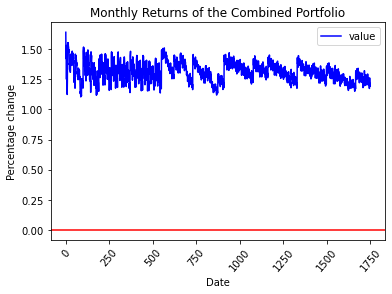

In [126]:
## Plot data for the Monthly Returns of the Combined portfolio
plt.plot(pd.DataFrame(all_weights).index,pd.DataFrame(all_weights)[0], ls='-', color='b', label = "value")
## Draw a line at y=0
plt.axhline(y=0,color='r',linestyle='-')
## Define the title
plt.title('Monthly Returns of the Combined Portfolio')
## Formatting
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=50)
# Create legend
plt.legend(loc='best')
## Display the graph
plt.show()

In [97]:
new_list_of_weights = []
for x in range(len(total_list)):
    new_list_of_weights.append(list_of_weights[x//2]+5)
new_list_of_weights

[5, 5, 5, 5, 5, 5, 5, 5, 15, 15, 5, 5, 5, 5, 5, 5, 45, 45, 5, 5]

In [98]:
final_list = []
for x in range (len(list_tuple)):
    final_list += list_tuple[x]

In [99]:
temp = pd.DataFrame(final_list)

In [100]:
temp['Weights']=0
for x in range (len(list_tuple)):
    for y in range (len(list_tuple[x])):
        temp['Weights'] = pd.Series(new_list_of_weights)
temp.head()

,0,Weights
0,SPG,5
1,ABT,5
2,KMI,5
3,NEE,5
4,SBUX,5


In [55]:
temp['Weights'].iloc[6]

IndexError: single positional indexer is out-of-bounds

In [ ]:
def make_frame(list_of_stocks, weights):
    

In [103]:
purchase_int = '2021-10-26'
purchase_fin = '2021-10-27'

In [102]:
purchase_int = '2021-10-26'
purchase_fin = '2021-10-27'
FinalPortfolio = make_frame(list_tuple,list_of_weights)


NameError: name 'make_frame' is not defined

In [117]:
def purchase_shares(pair_list,weights):
    ticker_frame = []
    for x in range (len(pair_list)):
        temp_tick = yf.Ticker(pair_list[x])
        temp_hist = temp_tick.history(start=purchase_int,end=purchase_fin)
        temp_close = temp_hist['Close'].iloc[0]
        temp_percentage = (1/len(pair_list))*(weights+5)
        shares = (((temp_percentage/100)*100000)/temp_close)
        value = ((temp_percentage/100)*100000)
        ticker_frame.append((pair_list[x],temp_close,shares,value,temp_percentage))
    return ticker_frame


In [118]:
FinalList = []
for x in range(len(list_tuple)):
    FinalList += purchase_shares(list_tuple[x],list_of_weights[x])
#FinalPortfolio['Balance'] = FinalPortfolio.sum(axis=1)
FinalPortfolio = pd.DataFrame(FinalList)
FinalPortfolio.columns = ['Ticker','Price','Shares','Value','Weight']
FinalPortfolio.index+=1

In [119]:
FinalPortfolio.head(25)

,Ticker,Price,Shares,Value,Weight
1,SPG,146.369995,17.080003,2500.0,2.5
2,ABT,128.130005,19.511433,2500.0,2.5
3,KMI,17.345800,144.127105,2500.0,2.5
4,NEE,85.093117,29.379580,2500.0,2.5
5,SBUX,114.426613,21.848064,2500.0,2.5
6,CVS,88.320000,28.306160,2500.0,2.5
7,GOOG,2793.439941,0.894954,2500.0,2.5
8,LMT,331.910004,7.532162,2500.0,2.5
9,MSFT,309.543671,24.229215,7500.0,7.5
10,MON,9.760000,768.442605,7500.0,7.5


In [120]:
FinalPortfolio['Value'].sum(axis=0)

100000.0

In [121]:
FinalPortfolio['Weight'].sum(axis=0)

100.0

In [35]:
FinalPortfolio.to_csv(r'C:Stocks_Group_15.csv')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.